# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=350  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=64, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=64, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


     


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), (1024,1)]
    #cfg = [48, (96,2), 96, (192,2), 192, (384,2), 384, 384, 384, 384, 384, (768,2), (1024,1)]
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512,1024,1024]
    #cfg = [48, (96,2), 96, (192,2), 192, (384,2), 384, 384, 384, 384, 384,768,1024]
    cfg = [32, (64,2), 64, (128,2), 128, (256,2), 256, 256, 256, 256, 256,528,1024]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        #print("X",out.shape)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1=open("Cifar10_INFO.txt","a+")
            f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=80 and (epoch-80)%10==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.306823, Accuracy: 8.98
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.267574, Accuracy: 13.48
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.157700, Accuracy: 17.58
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.086734, Accuracy: 18.36
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.982983, Accuracy: 23.83
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.935478, Accuracy: 27.73
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.955475, Accuracy: 26.56
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.795297, Accuracy: 30.47
Train Epoch: 0 [20480/50000 (45%)]	Loss: 1.794728, Accuracy: 31.64
Train Epoch: 0 [23040/50000 (51%)]	Loss: 1.780646, Accuracy: 32.03
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.799306, Accuracy: 29.88
Train Epoch: 0 [28160/50000 (62%)]	Loss: 1.713152, Accuracy: 35.16
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.800080, Accuracy: 35.55
Train Epoch: 0 [33280/50000 (74%)]	Loss: 1.674268, Accuracy: 36.72
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.702289, Accuracy: 36.13
Train

Train Epoch: 6 [12800/50000 (28%)]	Loss: 0.926204, Accuracy: 67.77
Train Epoch: 6 [15360/50000 (34%)]	Loss: 0.868603, Accuracy: 66.60
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.927116, Accuracy: 65.62
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.974702, Accuracy: 63.09
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.934193, Accuracy: 67.97
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.857348, Accuracy: 67.19
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.816042, Accuracy: 69.73
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.891552, Accuracy: 67.38
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.968075, Accuracy: 66.41
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.878514, Accuracy: 69.73
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.800361, Accuracy: 72.27
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.878535, Accuracy: 66.41
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.880630, Accuracy: 69.92

Validation set: Average loss: 1.0916, Accuracy: 3100/5000 (62.00%)

the time of this epoch:[16.294405698776245 s]
Train Epoch: 7

Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.583883, Accuracy: 79.69
Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.650649, Accuracy: 76.56
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.641372, Accuracy: 77.34
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.621488, Accuracy: 78.91
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.617405, Accuracy: 76.95
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.579805, Accuracy: 79.88
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.581721, Accuracy: 79.30
Train Epoch: 12 [43520/50000 (97%)]	Loss: 0.634255, Accuracy: 79.88

Validation set: Average loss: 1.0051, Accuracy: 3319/5000 (66.00%)

the time of this epoch:[16.31087827682495 s]
Train Epoch: 13 [0/50000 (0%)]	Loss: 0.547001, Accuracy: 80.27
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.559595, Accuracy: 79.88
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.580995, Accuracy: 81.84
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.592085, Accuracy: 79.88
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.618724, Accuracy: 77.93
Train Epoch

Train Epoch: 18 [35840/50000 (80%)]	Loss: 0.485068, Accuracy: 83.40
Train Epoch: 18 [38400/50000 (85%)]	Loss: 0.478283, Accuracy: 83.40
Train Epoch: 18 [40960/50000 (91%)]	Loss: 0.460388, Accuracy: 82.81
Train Epoch: 18 [43520/50000 (97%)]	Loss: 0.573833, Accuracy: 79.88

Validation set: Average loss: 0.7316, Accuracy: 3731/5000 (74.00%)

the time of this epoch:[15.721923828125 s]
Train Epoch: 19 [0/50000 (0%)]	Loss: 0.555056, Accuracy: 81.45
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.578528, Accuracy: 80.86
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.438705, Accuracy: 84.38
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.514376, Accuracy: 82.62
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.501090, Accuracy: 83.01
Train Epoch: 19 [12800/50000 (28%)]	Loss: 0.479161, Accuracy: 83.40
Train Epoch: 19 [15360/50000 (34%)]	Loss: 0.540333, Accuracy: 81.25
Train Epoch: 19 [17920/50000 (40%)]	Loss: 0.611779, Accuracy: 78.32
Train Epoch: 19 [20480/50000 (45%)]	Loss: 0.536073, Accuracy: 81.05
Train Epoch: 


Validation set: Average loss: 0.8480, Accuracy: 3588/5000 (71.00%)

the time of this epoch:[16.12452983856201 s]
Train Epoch: 25 [0/50000 (0%)]	Loss: 0.410244, Accuracy: 85.74
Train Epoch: 25 [2560/50000 (6%)]	Loss: 0.444374, Accuracy: 83.98
Train Epoch: 25 [5120/50000 (11%)]	Loss: 0.448907, Accuracy: 84.57
Train Epoch: 25 [7680/50000 (17%)]	Loss: 0.444681, Accuracy: 84.38
Train Epoch: 25 [10240/50000 (23%)]	Loss: 0.502102, Accuracy: 82.42
Train Epoch: 25 [12800/50000 (28%)]	Loss: 0.470858, Accuracy: 84.18
Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.524123, Accuracy: 82.42
Train Epoch: 25 [17920/50000 (40%)]	Loss: 0.500098, Accuracy: 84.18
Train Epoch: 25 [20480/50000 (45%)]	Loss: 0.478284, Accuracy: 82.81
Train Epoch: 25 [23040/50000 (51%)]	Loss: 0.453410, Accuracy: 83.40
Train Epoch: 25 [25600/50000 (57%)]	Loss: 0.493991, Accuracy: 81.84
Train Epoch: 25 [28160/50000 (62%)]	Loss: 0.474125, Accuracy: 84.18
Train Epoch: 25 [30720/50000 (68%)]	Loss: 0.496556, Accuracy: 83.40
Train Epoch

Train Epoch: 31 [5120/50000 (11%)]	Loss: 0.464940, Accuracy: 82.23
Train Epoch: 31 [7680/50000 (17%)]	Loss: 0.419731, Accuracy: 84.77
Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.423797, Accuracy: 85.16
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.491428, Accuracy: 84.18
Train Epoch: 31 [15360/50000 (34%)]	Loss: 0.388609, Accuracy: 87.70
Train Epoch: 31 [17920/50000 (40%)]	Loss: 0.439734, Accuracy: 85.16
Train Epoch: 31 [20480/50000 (45%)]	Loss: 0.390989, Accuracy: 87.70
Train Epoch: 31 [23040/50000 (51%)]	Loss: 0.410238, Accuracy: 84.96
Train Epoch: 31 [25600/50000 (57%)]	Loss: 0.427628, Accuracy: 84.18
Train Epoch: 31 [28160/50000 (62%)]	Loss: 0.424923, Accuracy: 85.16
Train Epoch: 31 [30720/50000 (68%)]	Loss: 0.471701, Accuracy: 83.79
Train Epoch: 31 [33280/50000 (74%)]	Loss: 0.451623, Accuracy: 84.96
Train Epoch: 31 [35840/50000 (80%)]	Loss: 0.464834, Accuracy: 82.81
Train Epoch: 31 [38400/50000 (85%)]	Loss: 0.462060, Accuracy: 84.38
Train Epoch: 31 [40960/50000 (91%)]	Loss: 0.408442

Train Epoch: 37 [15360/50000 (34%)]	Loss: 0.409602, Accuracy: 86.72
Train Epoch: 37 [17920/50000 (40%)]	Loss: 0.496619, Accuracy: 83.20
Train Epoch: 37 [20480/50000 (45%)]	Loss: 0.389340, Accuracy: 86.33
Train Epoch: 37 [23040/50000 (51%)]	Loss: 0.429333, Accuracy: 86.91
Train Epoch: 37 [25600/50000 (57%)]	Loss: 0.446855, Accuracy: 84.38
Train Epoch: 37 [28160/50000 (62%)]	Loss: 0.415680, Accuracy: 86.13
Train Epoch: 37 [30720/50000 (68%)]	Loss: 0.385524, Accuracy: 86.72
Train Epoch: 37 [33280/50000 (74%)]	Loss: 0.405653, Accuracy: 85.55
Train Epoch: 37 [35840/50000 (80%)]	Loss: 0.453260, Accuracy: 83.98
Train Epoch: 37 [38400/50000 (85%)]	Loss: 0.348775, Accuracy: 88.67
Train Epoch: 37 [40960/50000 (91%)]	Loss: 0.436378, Accuracy: 84.38
Train Epoch: 37 [43520/50000 (97%)]	Loss: 0.458638, Accuracy: 82.62

Validation set: Average loss: 0.6232, Accuracy: 3946/5000 (78.00%)

the time of this epoch:[16.30303382873535 s]
Train Epoch: 38 [0/50000 (0%)]	Loss: 0.366387, Accuracy: 89.45
Train E

Train Epoch: 43 [25600/50000 (57%)]	Loss: 0.401199, Accuracy: 86.13
Train Epoch: 43 [28160/50000 (62%)]	Loss: 0.386058, Accuracy: 85.94
Train Epoch: 43 [30720/50000 (68%)]	Loss: 0.383618, Accuracy: 85.94
Train Epoch: 43 [33280/50000 (74%)]	Loss: 0.414135, Accuracy: 86.91
Train Epoch: 43 [35840/50000 (80%)]	Loss: 0.445021, Accuracy: 85.35
Train Epoch: 43 [38400/50000 (85%)]	Loss: 0.333863, Accuracy: 89.06
Train Epoch: 43 [40960/50000 (91%)]	Loss: 0.330087, Accuracy: 89.26
Train Epoch: 43 [43520/50000 (97%)]	Loss: 0.457240, Accuracy: 85.35

Validation set: Average loss: 0.6044, Accuracy: 3996/5000 (79.00%)

the time of this epoch:[15.716937780380249 s]
Train Epoch: 44 [0/50000 (0%)]	Loss: 0.414421, Accuracy: 84.57
Train Epoch: 44 [2560/50000 (6%)]	Loss: 0.331293, Accuracy: 88.28
Train Epoch: 44 [5120/50000 (11%)]	Loss: 0.339234, Accuracy: 89.06
Train Epoch: 44 [7680/50000 (17%)]	Loss: 0.378714, Accuracy: 87.70
Train Epoch: 44 [10240/50000 (23%)]	Loss: 0.335838, Accuracy: 88.48
Train Epoc

Train Epoch: 49 [35840/50000 (80%)]	Loss: 0.394757, Accuracy: 85.94
Train Epoch: 49 [38400/50000 (85%)]	Loss: 0.368874, Accuracy: 85.16
Train Epoch: 49 [40960/50000 (91%)]	Loss: 0.414894, Accuracy: 85.74
Train Epoch: 49 [43520/50000 (97%)]	Loss: 0.368509, Accuracy: 87.70

Validation set: Average loss: 0.6528, Accuracy: 3946/5000 (78.00%)

the time of this epoch:[16.290762901306152 s]
Train Epoch: 50 [0/50000 (0%)]	Loss: 0.367242, Accuracy: 86.33
Train Epoch: 50 [2560/50000 (6%)]	Loss: 0.325622, Accuracy: 89.45
Train Epoch: 50 [5120/50000 (11%)]	Loss: 0.429696, Accuracy: 87.30
Train Epoch: 50 [7680/50000 (17%)]	Loss: 0.346984, Accuracy: 87.70
Train Epoch: 50 [10240/50000 (23%)]	Loss: 0.341498, Accuracy: 87.50
Train Epoch: 50 [12800/50000 (28%)]	Loss: 0.409111, Accuracy: 86.91
Train Epoch: 50 [15360/50000 (34%)]	Loss: 0.376152, Accuracy: 86.52
Train Epoch: 50 [17920/50000 (40%)]	Loss: 0.389832, Accuracy: 86.91
Train Epoch: 50 [20480/50000 (45%)]	Loss: 0.347201, Accuracy: 87.89
Train Epoc


Validation set: Average loss: 0.8542, Accuracy: 3659/5000 (73.00%)

the time of this epoch:[16.06091022491455 s]
Train Epoch: 56 [0/50000 (0%)]	Loss: 0.305540, Accuracy: 89.45
Train Epoch: 56 [2560/50000 (6%)]	Loss: 0.388506, Accuracy: 85.16
Train Epoch: 56 [5120/50000 (11%)]	Loss: 0.339498, Accuracy: 88.09
Train Epoch: 56 [7680/50000 (17%)]	Loss: 0.378681, Accuracy: 88.28
Train Epoch: 56 [10240/50000 (23%)]	Loss: 0.338680, Accuracy: 88.87
Train Epoch: 56 [12800/50000 (28%)]	Loss: 0.386901, Accuracy: 86.33
Train Epoch: 56 [15360/50000 (34%)]	Loss: 0.374491, Accuracy: 86.13
Train Epoch: 56 [17920/50000 (40%)]	Loss: 0.378853, Accuracy: 86.72
Train Epoch: 56 [20480/50000 (45%)]	Loss: 0.369922, Accuracy: 87.11
Train Epoch: 56 [23040/50000 (51%)]	Loss: 0.388532, Accuracy: 87.50
Train Epoch: 56 [25600/50000 (57%)]	Loss: 0.499098, Accuracy: 83.40
Train Epoch: 56 [28160/50000 (62%)]	Loss: 0.480495, Accuracy: 84.77
Train Epoch: 56 [30720/50000 (68%)]	Loss: 0.396164, Accuracy: 86.13
Train Epoch

Train Epoch: 62 [5120/50000 (11%)]	Loss: 0.343843, Accuracy: 88.28
Train Epoch: 62 [7680/50000 (17%)]	Loss: 0.329167, Accuracy: 89.26
Train Epoch: 62 [10240/50000 (23%)]	Loss: 0.373942, Accuracy: 87.50
Train Epoch: 62 [12800/50000 (28%)]	Loss: 0.389792, Accuracy: 85.55
Train Epoch: 62 [15360/50000 (34%)]	Loss: 0.382483, Accuracy: 86.33
Train Epoch: 62 [17920/50000 (40%)]	Loss: 0.313902, Accuracy: 89.45
Train Epoch: 62 [20480/50000 (45%)]	Loss: 0.401678, Accuracy: 85.94
Train Epoch: 62 [23040/50000 (51%)]	Loss: 0.356744, Accuracy: 88.87
Train Epoch: 62 [25600/50000 (57%)]	Loss: 0.294503, Accuracy: 89.84
Train Epoch: 62 [28160/50000 (62%)]	Loss: 0.359935, Accuracy: 86.13
Train Epoch: 62 [30720/50000 (68%)]	Loss: 0.330507, Accuracy: 88.09
Train Epoch: 62 [33280/50000 (74%)]	Loss: 0.390067, Accuracy: 85.94
Train Epoch: 62 [35840/50000 (80%)]	Loss: 0.308219, Accuracy: 88.67
Train Epoch: 62 [38400/50000 (85%)]	Loss: 0.392336, Accuracy: 85.74
Train Epoch: 62 [40960/50000 (91%)]	Loss: 0.410063

Train Epoch: 68 [15360/50000 (34%)]	Loss: 0.295741, Accuracy: 88.87
Train Epoch: 68 [17920/50000 (40%)]	Loss: 0.366686, Accuracy: 87.50
Train Epoch: 68 [20480/50000 (45%)]	Loss: 0.327762, Accuracy: 87.89
Train Epoch: 68 [23040/50000 (51%)]	Loss: 0.364399, Accuracy: 88.09
Train Epoch: 68 [25600/50000 (57%)]	Loss: 0.426456, Accuracy: 84.96
Train Epoch: 68 [28160/50000 (62%)]	Loss: 0.399943, Accuracy: 86.72
Train Epoch: 68 [30720/50000 (68%)]	Loss: 0.424839, Accuracy: 85.35
Train Epoch: 68 [33280/50000 (74%)]	Loss: 0.375663, Accuracy: 86.33
Train Epoch: 68 [35840/50000 (80%)]	Loss: 0.475356, Accuracy: 83.79
Train Epoch: 68 [38400/50000 (85%)]	Loss: 0.412537, Accuracy: 86.91
Train Epoch: 68 [40960/50000 (91%)]	Loss: 0.407072, Accuracy: 85.74
Train Epoch: 68 [43520/50000 (97%)]	Loss: 0.406879, Accuracy: 85.74

Validation set: Average loss: 0.6202, Accuracy: 4009/5000 (80.00%)

the time of this epoch:[16.237988471984863 s]
Train Epoch: 69 [0/50000 (0%)]	Loss: 0.350754, Accuracy: 88.67
Train 

Train Epoch: 74 [25600/50000 (57%)]	Loss: 0.291222, Accuracy: 90.23
Train Epoch: 74 [28160/50000 (62%)]	Loss: 0.403924, Accuracy: 85.74
Train Epoch: 74 [30720/50000 (68%)]	Loss: 0.262987, Accuracy: 90.62
Train Epoch: 74 [33280/50000 (74%)]	Loss: 0.360362, Accuracy: 87.89
Train Epoch: 74 [35840/50000 (80%)]	Loss: 0.406141, Accuracy: 84.77
Train Epoch: 74 [38400/50000 (85%)]	Loss: 0.431066, Accuracy: 85.74
Train Epoch: 74 [40960/50000 (91%)]	Loss: 0.315166, Accuracy: 88.48
Train Epoch: 74 [43520/50000 (97%)]	Loss: 0.358865, Accuracy: 88.48

Validation set: Average loss: 0.8680, Accuracy: 3652/5000 (73.00%)

the time of this epoch:[16.004168272018433 s]
Train Epoch: 75 [0/50000 (0%)]	Loss: 0.354112, Accuracy: 88.09
Train Epoch: 75 [2560/50000 (6%)]	Loss: 0.310499, Accuracy: 90.23
Train Epoch: 75 [5120/50000 (11%)]	Loss: 0.371735, Accuracy: 85.35
Train Epoch: 75 [7680/50000 (17%)]	Loss: 0.330067, Accuracy: 89.26
Train Epoch: 75 [10240/50000 (23%)]	Loss: 0.296232, Accuracy: 90.04
Train Epoc

Train Epoch: 80 [35840/50000 (80%)]	Loss: 0.383756, Accuracy: 86.52
Train Epoch: 80 [38400/50000 (85%)]	Loss: 0.322295, Accuracy: 88.28
Train Epoch: 80 [40960/50000 (91%)]	Loss: 0.305737, Accuracy: 89.45
Train Epoch: 80 [43520/50000 (97%)]	Loss: 0.397598, Accuracy: 87.50

Validation set: Average loss: 0.5706, Accuracy: 4064/5000 (81.00%)

the time of this epoch:[16.237184524536133 s]

Test set: Average loss: 0.6153, Accuracy: 8030/10000 (80.30%)

Train Epoch: 81 [0/50000 (0%)]	Loss: 0.347945, Accuracy: 87.50
Train Epoch: 81 [2560/50000 (6%)]	Loss: 0.275470, Accuracy: 90.23
Train Epoch: 81 [5120/50000 (11%)]	Loss: 0.380707, Accuracy: 86.72
Train Epoch: 81 [7680/50000 (17%)]	Loss: 0.319303, Accuracy: 89.45
Train Epoch: 81 [10240/50000 (23%)]	Loss: 0.351690, Accuracy: 86.52
Train Epoch: 81 [12800/50000 (28%)]	Loss: 0.424214, Accuracy: 86.52
Train Epoch: 81 [15360/50000 (34%)]	Loss: 0.370697, Accuracy: 87.11
Train Epoch: 81 [17920/50000 (40%)]	Loss: 0.305523, Accuracy: 90.62
Train Epoch: 8

Train Epoch: 86 [43520/50000 (97%)]	Loss: 0.299673, Accuracy: 88.67

Validation set: Average loss: 0.6681, Accuracy: 3909/5000 (78.00%)

the time of this epoch:[16.26203417778015 s]
Train Epoch: 87 [0/50000 (0%)]	Loss: 0.363522, Accuracy: 87.89
Train Epoch: 87 [2560/50000 (6%)]	Loss: 0.333341, Accuracy: 89.26
Train Epoch: 87 [5120/50000 (11%)]	Loss: 0.331218, Accuracy: 87.70
Train Epoch: 87 [7680/50000 (17%)]	Loss: 0.377500, Accuracy: 87.30
Train Epoch: 87 [10240/50000 (23%)]	Loss: 0.281280, Accuracy: 91.41
Train Epoch: 87 [12800/50000 (28%)]	Loss: 0.310503, Accuracy: 90.04
Train Epoch: 87 [15360/50000 (34%)]	Loss: 0.366373, Accuracy: 88.48
Train Epoch: 87 [17920/50000 (40%)]	Loss: 0.344521, Accuracy: 88.67
Train Epoch: 87 [20480/50000 (45%)]	Loss: 0.358522, Accuracy: 88.67
Train Epoch: 87 [23040/50000 (51%)]	Loss: 0.377085, Accuracy: 87.11
Train Epoch: 87 [25600/50000 (57%)]	Loss: 0.303267, Accuracy: 89.06
Train Epoch: 87 [28160/50000 (62%)]	Loss: 0.393195, Accuracy: 84.96
Train Epoch

Train Epoch: 93 [2560/50000 (6%)]	Loss: 0.351744, Accuracy: 87.70
Train Epoch: 93 [5120/50000 (11%)]	Loss: 0.259634, Accuracy: 91.21
Train Epoch: 93 [7680/50000 (17%)]	Loss: 0.338532, Accuracy: 87.50
Train Epoch: 93 [10240/50000 (23%)]	Loss: 0.355503, Accuracy: 88.67
Train Epoch: 93 [12800/50000 (28%)]	Loss: 0.337805, Accuracy: 86.52
Train Epoch: 93 [15360/50000 (34%)]	Loss: 0.318961, Accuracy: 88.28
Train Epoch: 93 [17920/50000 (40%)]	Loss: 0.297157, Accuracy: 90.04
Train Epoch: 93 [20480/50000 (45%)]	Loss: 0.361224, Accuracy: 88.28
Train Epoch: 93 [23040/50000 (51%)]	Loss: 0.241743, Accuracy: 91.80
Train Epoch: 93 [25600/50000 (57%)]	Loss: 0.350758, Accuracy: 89.26
Train Epoch: 93 [28160/50000 (62%)]	Loss: 0.345634, Accuracy: 87.30
Train Epoch: 93 [30720/50000 (68%)]	Loss: 0.360182, Accuracy: 87.50
Train Epoch: 93 [33280/50000 (74%)]	Loss: 0.331803, Accuracy: 87.50
Train Epoch: 93 [35840/50000 (80%)]	Loss: 0.328324, Accuracy: 88.87
Train Epoch: 93 [38400/50000 (85%)]	Loss: 0.418263, 

Train Epoch: 99 [12800/50000 (28%)]	Loss: 0.338434, Accuracy: 88.09
Train Epoch: 99 [15360/50000 (34%)]	Loss: 0.382802, Accuracy: 86.72
Train Epoch: 99 [17920/50000 (40%)]	Loss: 0.382719, Accuracy: 87.70
Train Epoch: 99 [20480/50000 (45%)]	Loss: 0.257468, Accuracy: 90.62
Train Epoch: 99 [23040/50000 (51%)]	Loss: 0.356473, Accuracy: 86.13
Train Epoch: 99 [25600/50000 (57%)]	Loss: 0.289687, Accuracy: 90.04
Train Epoch: 99 [28160/50000 (62%)]	Loss: 0.349571, Accuracy: 88.09
Train Epoch: 99 [30720/50000 (68%)]	Loss: 0.379050, Accuracy: 85.94
Train Epoch: 99 [33280/50000 (74%)]	Loss: 0.340123, Accuracy: 87.30
Train Epoch: 99 [35840/50000 (80%)]	Loss: 0.374434, Accuracy: 87.30
Train Epoch: 99 [38400/50000 (85%)]	Loss: 0.385623, Accuracy: 87.30
Train Epoch: 99 [40960/50000 (91%)]	Loss: 0.396239, Accuracy: 87.30
Train Epoch: 99 [43520/50000 (97%)]	Loss: 0.359296, Accuracy: 87.30

Validation set: Average loss: 0.5265, Accuracy: 4099/5000 (81.00%)

the time of this epoch:[16.27024269104004 s]
Tr

Train Epoch: 105 [15360/50000 (34%)]	Loss: 0.175113, Accuracy: 94.14
Train Epoch: 105 [17920/50000 (40%)]	Loss: 0.190436, Accuracy: 93.55
Train Epoch: 105 [20480/50000 (45%)]	Loss: 0.164094, Accuracy: 94.53
Train Epoch: 105 [23040/50000 (51%)]	Loss: 0.140080, Accuracy: 95.90
Train Epoch: 105 [25600/50000 (57%)]	Loss: 0.185591, Accuracy: 92.97
Train Epoch: 105 [28160/50000 (62%)]	Loss: 0.137822, Accuracy: 94.92
Train Epoch: 105 [30720/50000 (68%)]	Loss: 0.215746, Accuracy: 92.38
Train Epoch: 105 [33280/50000 (74%)]	Loss: 0.197268, Accuracy: 92.38
Train Epoch: 105 [35840/50000 (80%)]	Loss: 0.174109, Accuracy: 94.53
Train Epoch: 105 [38400/50000 (85%)]	Loss: 0.179185, Accuracy: 94.34
Train Epoch: 105 [40960/50000 (91%)]	Loss: 0.124966, Accuracy: 95.31
Train Epoch: 105 [43520/50000 (97%)]	Loss: 0.122365, Accuracy: 95.70

Validation set: Average loss: 0.2877, Accuracy: 4516/5000 (90.00%)

the time of this epoch:[16.24863338470459 s]
Train Epoch: 106 [0/50000 (0%)]	Loss: 0.160562, Accuracy: 

Train Epoch: 111 [17920/50000 (40%)]	Loss: 0.148414, Accuracy: 94.53
Train Epoch: 111 [20480/50000 (45%)]	Loss: 0.161652, Accuracy: 94.53
Train Epoch: 111 [23040/50000 (51%)]	Loss: 0.128178, Accuracy: 96.09
Train Epoch: 111 [25600/50000 (57%)]	Loss: 0.137327, Accuracy: 95.12
Train Epoch: 111 [28160/50000 (62%)]	Loss: 0.117963, Accuracy: 96.09
Train Epoch: 111 [30720/50000 (68%)]	Loss: 0.110382, Accuracy: 96.68
Train Epoch: 111 [33280/50000 (74%)]	Loss: 0.102547, Accuracy: 97.27
Train Epoch: 111 [35840/50000 (80%)]	Loss: 0.132744, Accuracy: 95.70
Train Epoch: 111 [38400/50000 (85%)]	Loss: 0.140009, Accuracy: 95.31
Train Epoch: 111 [40960/50000 (91%)]	Loss: 0.126788, Accuracy: 95.70
Train Epoch: 111 [43520/50000 (97%)]	Loss: 0.136719, Accuracy: 95.70

Validation set: Average loss: 0.3004, Accuracy: 4505/5000 (90.00%)

the time of this epoch:[17.994774341583252 s]
Train Epoch: 112 [0/50000 (0%)]	Loss: 0.104115, Accuracy: 96.68
Train Epoch: 112 [2560/50000 (6%)]	Loss: 0.121897, Accuracy: 9

Train Epoch: 117 [23040/50000 (51%)]	Loss: 0.087753, Accuracy: 97.07
Train Epoch: 117 [25600/50000 (57%)]	Loss: 0.105510, Accuracy: 96.88
Train Epoch: 117 [28160/50000 (62%)]	Loss: 0.112946, Accuracy: 95.70
Train Epoch: 117 [30720/50000 (68%)]	Loss: 0.131984, Accuracy: 95.51
Train Epoch: 117 [33280/50000 (74%)]	Loss: 0.120754, Accuracy: 95.70
Train Epoch: 117 [35840/50000 (80%)]	Loss: 0.133062, Accuracy: 95.90
Train Epoch: 117 [38400/50000 (85%)]	Loss: 0.089811, Accuracy: 97.07
Train Epoch: 117 [40960/50000 (91%)]	Loss: 0.164519, Accuracy: 95.12
Train Epoch: 117 [43520/50000 (97%)]	Loss: 0.103223, Accuracy: 95.90

Validation set: Average loss: 0.3173, Accuracy: 4522/5000 (90.00%)

the time of this epoch:[16.264857292175293 s]
Train Epoch: 118 [0/50000 (0%)]	Loss: 0.115390, Accuracy: 96.09
Train Epoch: 118 [2560/50000 (6%)]	Loss: 0.082529, Accuracy: 96.88
Train Epoch: 118 [5120/50000 (11%)]	Loss: 0.099900, Accuracy: 96.29
Train Epoch: 118 [7680/50000 (17%)]	Loss: 0.097102, Accuracy: 96.

Train Epoch: 123 [25600/50000 (57%)]	Loss: 0.110375, Accuracy: 96.48
Train Epoch: 123 [28160/50000 (62%)]	Loss: 0.087322, Accuracy: 97.27
Train Epoch: 123 [30720/50000 (68%)]	Loss: 0.109117, Accuracy: 95.70
Train Epoch: 123 [33280/50000 (74%)]	Loss: 0.136864, Accuracy: 94.73
Train Epoch: 123 [35840/50000 (80%)]	Loss: 0.094053, Accuracy: 96.68
Train Epoch: 123 [38400/50000 (85%)]	Loss: 0.141099, Accuracy: 95.70
Train Epoch: 123 [40960/50000 (91%)]	Loss: 0.089765, Accuracy: 97.27
Train Epoch: 123 [43520/50000 (97%)]	Loss: 0.076622, Accuracy: 97.27

Validation set: Average loss: 0.3329, Accuracy: 4512/5000 (90.00%)

the time of this epoch:[16.08384871482849 s]
Train Epoch: 124 [0/50000 (0%)]	Loss: 0.099614, Accuracy: 96.09
Train Epoch: 124 [2560/50000 (6%)]	Loss: 0.098489, Accuracy: 96.29
Train Epoch: 124 [5120/50000 (11%)]	Loss: 0.083383, Accuracy: 96.68
Train Epoch: 124 [7680/50000 (17%)]	Loss: 0.104123, Accuracy: 96.88
Train Epoch: 124 [10240/50000 (23%)]	Loss: 0.098195, Accuracy: 96.0

Train Epoch: 129 [30720/50000 (68%)]	Loss: 0.072426, Accuracy: 97.66
Train Epoch: 129 [33280/50000 (74%)]	Loss: 0.079960, Accuracy: 97.27
Train Epoch: 129 [35840/50000 (80%)]	Loss: 0.076123, Accuracy: 97.07
Train Epoch: 129 [38400/50000 (85%)]	Loss: 0.095597, Accuracy: 96.88
Train Epoch: 129 [40960/50000 (91%)]	Loss: 0.133662, Accuracy: 94.92
Train Epoch: 129 [43520/50000 (97%)]	Loss: 0.138110, Accuracy: 95.51

Validation set: Average loss: 0.3767, Accuracy: 4456/5000 (89.00%)

the time of this epoch:[16.220086812973022 s]
Train Epoch: 130 [0/50000 (0%)]	Loss: 0.081302, Accuracy: 97.27
Train Epoch: 130 [2560/50000 (6%)]	Loss: 0.090716, Accuracy: 96.29
Train Epoch: 130 [5120/50000 (11%)]	Loss: 0.096396, Accuracy: 96.29
Train Epoch: 130 [7680/50000 (17%)]	Loss: 0.124568, Accuracy: 95.51
Train Epoch: 130 [10240/50000 (23%)]	Loss: 0.085681, Accuracy: 97.07
Train Epoch: 130 [12800/50000 (28%)]	Loss: 0.074453, Accuracy: 97.85
Train Epoch: 130 [15360/50000 (34%)]	Loss: 0.083023, Accuracy: 97.

Train Epoch: 135 [33280/50000 (74%)]	Loss: 0.095798, Accuracy: 97.27
Train Epoch: 135 [35840/50000 (80%)]	Loss: 0.061970, Accuracy: 98.24
Train Epoch: 135 [38400/50000 (85%)]	Loss: 0.079057, Accuracy: 97.66
Train Epoch: 135 [40960/50000 (91%)]	Loss: 0.107125, Accuracy: 96.09
Train Epoch: 135 [43520/50000 (97%)]	Loss: 0.108844, Accuracy: 96.09

Validation set: Average loss: 0.3523, Accuracy: 4491/5000 (89.00%)

the time of this epoch:[16.223907232284546 s]
Train Epoch: 136 [0/50000 (0%)]	Loss: 0.061618, Accuracy: 97.66
Train Epoch: 136 [2560/50000 (6%)]	Loss: 0.078703, Accuracy: 97.07
Train Epoch: 136 [5120/50000 (11%)]	Loss: 0.089599, Accuracy: 96.88
Train Epoch: 136 [7680/50000 (17%)]	Loss: 0.073539, Accuracy: 97.85
Train Epoch: 136 [10240/50000 (23%)]	Loss: 0.056272, Accuracy: 98.05
Train Epoch: 136 [12800/50000 (28%)]	Loss: 0.078277, Accuracy: 97.07
Train Epoch: 136 [15360/50000 (34%)]	Loss: 0.117587, Accuracy: 96.68
Train Epoch: 136 [17920/50000 (40%)]	Loss: 0.064368, Accuracy: 97.

Train Epoch: 141 [35840/50000 (80%)]	Loss: 0.064866, Accuracy: 97.85
Train Epoch: 141 [38400/50000 (85%)]	Loss: 0.098368, Accuracy: 96.48
Train Epoch: 141 [40960/50000 (91%)]	Loss: 0.054601, Accuracy: 97.66
Train Epoch: 141 [43520/50000 (97%)]	Loss: 0.083989, Accuracy: 97.07

Validation set: Average loss: 0.3645, Accuracy: 4497/5000 (89.00%)

the time of this epoch:[17.962403535842896 s]
Train Epoch: 142 [0/50000 (0%)]	Loss: 0.076008, Accuracy: 96.88
Train Epoch: 142 [2560/50000 (6%)]	Loss: 0.044543, Accuracy: 98.44
Train Epoch: 142 [5120/50000 (11%)]	Loss: 0.069062, Accuracy: 97.85
Train Epoch: 142 [7680/50000 (17%)]	Loss: 0.055029, Accuracy: 98.05
Train Epoch: 142 [10240/50000 (23%)]	Loss: 0.082919, Accuracy: 96.68
Train Epoch: 142 [12800/50000 (28%)]	Loss: 0.058691, Accuracy: 97.46
Train Epoch: 142 [15360/50000 (34%)]	Loss: 0.066033, Accuracy: 98.05
Train Epoch: 142 [17920/50000 (40%)]	Loss: 0.051538, Accuracy: 98.24
Train Epoch: 142 [20480/50000 (45%)]	Loss: 0.090797, Accuracy: 96.

Train Epoch: 147 [40960/50000 (91%)]	Loss: 0.083969, Accuracy: 96.48
Train Epoch: 147 [43520/50000 (97%)]	Loss: 0.078813, Accuracy: 97.46

Validation set: Average loss: 0.3727, Accuracy: 4490/5000 (89.00%)

the time of this epoch:[16.227036714553833 s]
Train Epoch: 148 [0/50000 (0%)]	Loss: 0.067495, Accuracy: 97.27
Train Epoch: 148 [2560/50000 (6%)]	Loss: 0.085492, Accuracy: 97.07
Train Epoch: 148 [5120/50000 (11%)]	Loss: 0.060361, Accuracy: 98.83
Train Epoch: 148 [7680/50000 (17%)]	Loss: 0.062215, Accuracy: 98.44
Train Epoch: 148 [10240/50000 (23%)]	Loss: 0.086972, Accuracy: 96.88
Train Epoch: 148 [12800/50000 (28%)]	Loss: 0.092975, Accuracy: 96.48
Train Epoch: 148 [15360/50000 (34%)]	Loss: 0.071754, Accuracy: 97.66
Train Epoch: 148 [17920/50000 (40%)]	Loss: 0.089036, Accuracy: 97.07
Train Epoch: 148 [20480/50000 (45%)]	Loss: 0.089439, Accuracy: 96.48
Train Epoch: 148 [23040/50000 (51%)]	Loss: 0.045923, Accuracy: 98.44
Train Epoch: 148 [25600/50000 (57%)]	Loss: 0.072041, Accuracy: 97.

Train Epoch: 153 [43520/50000 (97%)]	Loss: 0.106303, Accuracy: 96.29

Validation set: Average loss: 0.3804, Accuracy: 4500/5000 (90.00%)

the time of this epoch:[15.693766117095947 s]
Train Epoch: 154 [0/50000 (0%)]	Loss: 0.066269, Accuracy: 98.44
Train Epoch: 154 [2560/50000 (6%)]	Loss: 0.095255, Accuracy: 97.07
Train Epoch: 154 [5120/50000 (11%)]	Loss: 0.069153, Accuracy: 97.66
Train Epoch: 154 [7680/50000 (17%)]	Loss: 0.063143, Accuracy: 97.46
Train Epoch: 154 [10240/50000 (23%)]	Loss: 0.096108, Accuracy: 97.07
Train Epoch: 154 [12800/50000 (28%)]	Loss: 0.064217, Accuracy: 98.05
Train Epoch: 154 [15360/50000 (34%)]	Loss: 0.079422, Accuracy: 97.66
Train Epoch: 154 [17920/50000 (40%)]	Loss: 0.057781, Accuracy: 97.66
Train Epoch: 154 [20480/50000 (45%)]	Loss: 0.066192, Accuracy: 98.05
Train Epoch: 154 [23040/50000 (51%)]	Loss: 0.091125, Accuracy: 96.29
Train Epoch: 154 [25600/50000 (57%)]	Loss: 0.062784, Accuracy: 97.46
Train Epoch: 154 [28160/50000 (62%)]	Loss: 0.060750, Accuracy: 98.

Train Epoch: 160 [2560/50000 (6%)]	Loss: 0.059237, Accuracy: 98.44
Train Epoch: 160 [5120/50000 (11%)]	Loss: 0.061352, Accuracy: 97.66
Train Epoch: 160 [7680/50000 (17%)]	Loss: 0.071760, Accuracy: 97.27
Train Epoch: 160 [10240/50000 (23%)]	Loss: 0.075771, Accuracy: 96.48
Train Epoch: 160 [12800/50000 (28%)]	Loss: 0.044148, Accuracy: 98.24
Train Epoch: 160 [15360/50000 (34%)]	Loss: 0.077419, Accuracy: 97.27
Train Epoch: 160 [17920/50000 (40%)]	Loss: 0.057290, Accuracy: 98.44
Train Epoch: 160 [20480/50000 (45%)]	Loss: 0.057691, Accuracy: 97.85
Train Epoch: 160 [23040/50000 (51%)]	Loss: 0.058438, Accuracy: 97.85
Train Epoch: 160 [25600/50000 (57%)]	Loss: 0.065548, Accuracy: 97.85
Train Epoch: 160 [28160/50000 (62%)]	Loss: 0.094056, Accuracy: 97.27
Train Epoch: 160 [30720/50000 (68%)]	Loss: 0.079296, Accuracy: 97.46
Train Epoch: 160 [33280/50000 (74%)]	Loss: 0.089769, Accuracy: 96.48
Train Epoch: 160 [35840/50000 (80%)]	Loss: 0.062722, Accuracy: 97.85
Train Epoch: 160 [38400/50000 (85%)]	L

Train Epoch: 166 [5120/50000 (11%)]	Loss: 0.039962, Accuracy: 99.02
Train Epoch: 166 [7680/50000 (17%)]	Loss: 0.059733, Accuracy: 97.46
Train Epoch: 166 [10240/50000 (23%)]	Loss: 0.059191, Accuracy: 98.24
Train Epoch: 166 [12800/50000 (28%)]	Loss: 0.114473, Accuracy: 96.29
Train Epoch: 166 [15360/50000 (34%)]	Loss: 0.062299, Accuracy: 98.63
Train Epoch: 166 [17920/50000 (40%)]	Loss: 0.058270, Accuracy: 97.46
Train Epoch: 166 [20480/50000 (45%)]	Loss: 0.071914, Accuracy: 97.27
Train Epoch: 166 [23040/50000 (51%)]	Loss: 0.070568, Accuracy: 97.46
Train Epoch: 166 [25600/50000 (57%)]	Loss: 0.070078, Accuracy: 97.27
Train Epoch: 166 [28160/50000 (62%)]	Loss: 0.073336, Accuracy: 97.27
Train Epoch: 166 [30720/50000 (68%)]	Loss: 0.075651, Accuracy: 97.46
Train Epoch: 166 [33280/50000 (74%)]	Loss: 0.057168, Accuracy: 98.05
Train Epoch: 166 [35840/50000 (80%)]	Loss: 0.096099, Accuracy: 96.48
Train Epoch: 166 [38400/50000 (85%)]	Loss: 0.048791, Accuracy: 98.24
Train Epoch: 166 [40960/50000 (91%)]

Train Epoch: 172 [7680/50000 (17%)]	Loss: 0.078978, Accuracy: 97.27
Train Epoch: 172 [10240/50000 (23%)]	Loss: 0.051436, Accuracy: 98.05
Train Epoch: 172 [12800/50000 (28%)]	Loss: 0.060025, Accuracy: 97.85
Train Epoch: 172 [15360/50000 (34%)]	Loss: 0.062338, Accuracy: 97.85
Train Epoch: 172 [17920/50000 (40%)]	Loss: 0.050502, Accuracy: 98.63
Train Epoch: 172 [20480/50000 (45%)]	Loss: 0.078920, Accuracy: 97.46
Train Epoch: 172 [23040/50000 (51%)]	Loss: 0.071589, Accuracy: 98.05
Train Epoch: 172 [25600/50000 (57%)]	Loss: 0.057028, Accuracy: 97.85
Train Epoch: 172 [28160/50000 (62%)]	Loss: 0.083076, Accuracy: 97.27
Train Epoch: 172 [30720/50000 (68%)]	Loss: 0.107236, Accuracy: 95.90
Train Epoch: 172 [33280/50000 (74%)]	Loss: 0.041671, Accuracy: 98.24
Train Epoch: 172 [35840/50000 (80%)]	Loss: 0.058975, Accuracy: 97.66
Train Epoch: 172 [38400/50000 (85%)]	Loss: 0.059150, Accuracy: 97.66
Train Epoch: 172 [40960/50000 (91%)]	Loss: 0.062912, Accuracy: 98.24
Train Epoch: 172 [43520/50000 (97%)

Train Epoch: 178 [12800/50000 (28%)]	Loss: 0.075613, Accuracy: 97.46
Train Epoch: 178 [15360/50000 (34%)]	Loss: 0.055692, Accuracy: 98.63
Train Epoch: 178 [17920/50000 (40%)]	Loss: 0.082390, Accuracy: 96.48
Train Epoch: 178 [20480/50000 (45%)]	Loss: 0.070177, Accuracy: 97.46
Train Epoch: 178 [23040/50000 (51%)]	Loss: 0.062326, Accuracy: 97.46
Train Epoch: 178 [25600/50000 (57%)]	Loss: 0.029689, Accuracy: 99.22
Train Epoch: 178 [28160/50000 (62%)]	Loss: 0.050912, Accuracy: 98.44
Train Epoch: 178 [30720/50000 (68%)]	Loss: 0.085116, Accuracy: 97.46
Train Epoch: 178 [33280/50000 (74%)]	Loss: 0.098460, Accuracy: 96.88
Train Epoch: 178 [35840/50000 (80%)]	Loss: 0.053327, Accuracy: 98.44
Train Epoch: 178 [38400/50000 (85%)]	Loss: 0.073571, Accuracy: 97.27
Train Epoch: 178 [40960/50000 (91%)]	Loss: 0.083931, Accuracy: 97.66
Train Epoch: 178 [43520/50000 (97%)]	Loss: 0.035809, Accuracy: 98.83

Validation set: Average loss: 0.3985, Accuracy: 4483/5000 (89.00%)

the time of this epoch:[16.0135419

Train Epoch: 184 [15360/50000 (34%)]	Loss: 0.035288, Accuracy: 99.22
Train Epoch: 184 [17920/50000 (40%)]	Loss: 0.060515, Accuracy: 98.44
Train Epoch: 184 [20480/50000 (45%)]	Loss: 0.067018, Accuracy: 98.44
Train Epoch: 184 [23040/50000 (51%)]	Loss: 0.050780, Accuracy: 98.24
Train Epoch: 184 [25600/50000 (57%)]	Loss: 0.091670, Accuracy: 97.07
Train Epoch: 184 [28160/50000 (62%)]	Loss: 0.061320, Accuracy: 97.66
Train Epoch: 184 [30720/50000 (68%)]	Loss: 0.067609, Accuracy: 97.07
Train Epoch: 184 [33280/50000 (74%)]	Loss: 0.059991, Accuracy: 97.27
Train Epoch: 184 [35840/50000 (80%)]	Loss: 0.059196, Accuracy: 97.66
Train Epoch: 184 [38400/50000 (85%)]	Loss: 0.067619, Accuracy: 97.85
Train Epoch: 184 [40960/50000 (91%)]	Loss: 0.043168, Accuracy: 99.02
Train Epoch: 184 [43520/50000 (97%)]	Loss: 0.067431, Accuracy: 98.05

Validation set: Average loss: 0.4039, Accuracy: 4473/5000 (89.00%)

the time of this epoch:[15.707594156265259 s]
Train Epoch: 185 [0/50000 (0%)]	Loss: 0.058123, Accuracy:

Train Epoch: 190 [20480/50000 (45%)]	Loss: 0.063123, Accuracy: 97.46
Train Epoch: 190 [23040/50000 (51%)]	Loss: 0.095415, Accuracy: 96.68
Train Epoch: 190 [25600/50000 (57%)]	Loss: 0.045181, Accuracy: 98.83
Train Epoch: 190 [28160/50000 (62%)]	Loss: 0.098067, Accuracy: 95.70
Train Epoch: 190 [30720/50000 (68%)]	Loss: 0.061993, Accuracy: 97.46
Train Epoch: 190 [33280/50000 (74%)]	Loss: 0.052591, Accuracy: 98.05
Train Epoch: 190 [35840/50000 (80%)]	Loss: 0.082498, Accuracy: 97.27
Train Epoch: 190 [38400/50000 (85%)]	Loss: 0.073936, Accuracy: 97.46
Train Epoch: 190 [40960/50000 (91%)]	Loss: 0.094162, Accuracy: 96.88
Train Epoch: 190 [43520/50000 (97%)]	Loss: 0.077582, Accuracy: 96.88

Validation set: Average loss: 0.4351, Accuracy: 4442/5000 (88.00%)

the time of this epoch:[16.248525857925415 s]

Test set: Average loss: 0.4731, Accuracy: 8818/10000 (88.18%)

Train Epoch: 191 [0/50000 (0%)]	Loss: 0.053345, Accuracy: 98.83
Train Epoch: 191 [2560/50000 (6%)]	Loss: 0.043470, Accuracy: 98.24


Train Epoch: 196 [23040/50000 (51%)]	Loss: 0.063697, Accuracy: 97.66
Train Epoch: 196 [25600/50000 (57%)]	Loss: 0.049001, Accuracy: 98.24
Train Epoch: 196 [28160/50000 (62%)]	Loss: 0.073559, Accuracy: 97.85
Train Epoch: 196 [30720/50000 (68%)]	Loss: 0.082161, Accuracy: 98.05
Train Epoch: 196 [33280/50000 (74%)]	Loss: 0.053369, Accuracy: 97.66
Train Epoch: 196 [35840/50000 (80%)]	Loss: 0.105073, Accuracy: 95.70
Train Epoch: 196 [38400/50000 (85%)]	Loss: 0.065859, Accuracy: 96.68
Train Epoch: 196 [40960/50000 (91%)]	Loss: 0.044850, Accuracy: 98.05
Train Epoch: 196 [43520/50000 (97%)]	Loss: 0.052736, Accuracy: 97.66

Validation set: Average loss: 0.4194, Accuracy: 4477/5000 (89.00%)

the time of this epoch:[16.224406242370605 s]
Train Epoch: 197 [0/50000 (0%)]	Loss: 0.075207, Accuracy: 97.66
Train Epoch: 197 [2560/50000 (6%)]	Loss: 0.048399, Accuracy: 98.05
Train Epoch: 197 [5120/50000 (11%)]	Loss: 0.086918, Accuracy: 97.07
Train Epoch: 197 [7680/50000 (17%)]	Loss: 0.067411, Accuracy: 97.

Train Epoch: 202 [25600/50000 (57%)]	Loss: 0.050269, Accuracy: 97.85
Train Epoch: 202 [28160/50000 (62%)]	Loss: 0.039444, Accuracy: 98.63
Train Epoch: 202 [30720/50000 (68%)]	Loss: 0.032456, Accuracy: 99.02
Train Epoch: 202 [33280/50000 (74%)]	Loss: 0.048229, Accuracy: 98.44
Train Epoch: 202 [35840/50000 (80%)]	Loss: 0.029841, Accuracy: 98.83
Train Epoch: 202 [38400/50000 (85%)]	Loss: 0.046575, Accuracy: 98.05
Train Epoch: 202 [40960/50000 (91%)]	Loss: 0.043675, Accuracy: 98.83
Train Epoch: 202 [43520/50000 (97%)]	Loss: 0.047956, Accuracy: 98.05

Validation set: Average loss: 0.3729, Accuracy: 4538/5000 (90.00%)

the time of this epoch:[15.685623407363892 s]
Train Epoch: 203 [0/50000 (0%)]	Loss: 0.025578, Accuracy: 99.02
Train Epoch: 203 [2560/50000 (6%)]	Loss: 0.030352, Accuracy: 99.02
Train Epoch: 203 [5120/50000 (11%)]	Loss: 0.033794, Accuracy: 99.02
Train Epoch: 203 [7680/50000 (17%)]	Loss: 0.025251, Accuracy: 99.22
Train Epoch: 203 [10240/50000 (23%)]	Loss: 0.042011, Accuracy: 98.

Train Epoch: 208 [30720/50000 (68%)]	Loss: 0.021256, Accuracy: 99.61
Train Epoch: 208 [33280/50000 (74%)]	Loss: 0.022279, Accuracy: 99.02
Train Epoch: 208 [35840/50000 (80%)]	Loss: 0.038461, Accuracy: 98.83
Train Epoch: 208 [38400/50000 (85%)]	Loss: 0.014496, Accuracy: 99.80
Train Epoch: 208 [40960/50000 (91%)]	Loss: 0.011519, Accuracy: 99.80
Train Epoch: 208 [43520/50000 (97%)]	Loss: 0.020595, Accuracy: 98.83

Validation set: Average loss: 0.3836, Accuracy: 4540/5000 (90.00%)

the time of this epoch:[15.713810443878174 s]
Train Epoch: 209 [0/50000 (0%)]	Loss: 0.015326, Accuracy: 99.41
Train Epoch: 209 [2560/50000 (6%)]	Loss: 0.026229, Accuracy: 99.41
Train Epoch: 209 [5120/50000 (11%)]	Loss: 0.040945, Accuracy: 98.83
Train Epoch: 209 [7680/50000 (17%)]	Loss: 0.022797, Accuracy: 99.22
Train Epoch: 209 [10240/50000 (23%)]	Loss: 0.019035, Accuracy: 99.41
Train Epoch: 209 [12800/50000 (28%)]	Loss: 0.050631, Accuracy: 98.83
Train Epoch: 209 [15360/50000 (34%)]	Loss: 0.037826, Accuracy: 98.

Train Epoch: 214 [33280/50000 (74%)]	Loss: 0.016510, Accuracy: 99.80
Train Epoch: 214 [35840/50000 (80%)]	Loss: 0.017061, Accuracy: 99.61
Train Epoch: 214 [38400/50000 (85%)]	Loss: 0.011773, Accuracy: 99.80
Train Epoch: 214 [40960/50000 (91%)]	Loss: 0.030007, Accuracy: 99.02
Train Epoch: 214 [43520/50000 (97%)]	Loss: 0.022718, Accuracy: 99.61

Validation set: Average loss: 0.3927, Accuracy: 4540/5000 (90.00%)

the time of this epoch:[16.25173807144165 s]
Train Epoch: 215 [0/50000 (0%)]	Loss: 0.014571, Accuracy: 99.80
Train Epoch: 215 [2560/50000 (6%)]	Loss: 0.023175, Accuracy: 99.41
Train Epoch: 215 [5120/50000 (11%)]	Loss: 0.017596, Accuracy: 99.80
Train Epoch: 215 [7680/50000 (17%)]	Loss: 0.031500, Accuracy: 98.83
Train Epoch: 215 [10240/50000 (23%)]	Loss: 0.018052, Accuracy: 99.80
Train Epoch: 215 [12800/50000 (28%)]	Loss: 0.008612, Accuracy: 100.00
Train Epoch: 215 [15360/50000 (34%)]	Loss: 0.029797, Accuracy: 99.02
Train Epoch: 215 [17920/50000 (40%)]	Loss: 0.019801, Accuracy: 99.

Train Epoch: 220 [38400/50000 (85%)]	Loss: 0.013953, Accuracy: 99.80
Train Epoch: 220 [40960/50000 (91%)]	Loss: 0.020150, Accuracy: 99.41
Train Epoch: 220 [43520/50000 (97%)]	Loss: 0.018514, Accuracy: 99.41

Validation set: Average loss: 0.3973, Accuracy: 4525/5000 (90.00%)

the time of this epoch:[16.197500228881836 s]

Test set: Average loss: 0.4491, Accuracy: 8978/10000 (89.78%)

Train Epoch: 221 [0/50000 (0%)]	Loss: 0.009553, Accuracy: 100.00
Train Epoch: 221 [2560/50000 (6%)]	Loss: 0.010889, Accuracy: 99.80
Train Epoch: 221 [5120/50000 (11%)]	Loss: 0.013032, Accuracy: 99.61
Train Epoch: 221 [7680/50000 (17%)]	Loss: 0.033955, Accuracy: 98.83
Train Epoch: 221 [10240/50000 (23%)]	Loss: 0.013928, Accuracy: 99.80
Train Epoch: 221 [12800/50000 (28%)]	Loss: 0.013541, Accuracy: 99.61
Train Epoch: 221 [15360/50000 (34%)]	Loss: 0.008961, Accuracy: 100.00
Train Epoch: 221 [17920/50000 (40%)]	Loss: 0.008987, Accuracy: 99.80
Train Epoch: 221 [20480/50000 (45%)]	Loss: 0.019757, Accuracy: 99.22


Train Epoch: 226 [40960/50000 (91%)]	Loss: 0.006577, Accuracy: 99.80
Train Epoch: 226 [43520/50000 (97%)]	Loss: 0.020049, Accuracy: 99.41

Validation set: Average loss: 0.4042, Accuracy: 4533/5000 (90.00%)

the time of this epoch:[16.41029691696167 s]
Train Epoch: 227 [0/50000 (0%)]	Loss: 0.013789, Accuracy: 99.61
Train Epoch: 227 [2560/50000 (6%)]	Loss: 0.010534, Accuracy: 99.61
Train Epoch: 227 [5120/50000 (11%)]	Loss: 0.021271, Accuracy: 99.02
Train Epoch: 227 [7680/50000 (17%)]	Loss: 0.012059, Accuracy: 99.41
Train Epoch: 227 [10240/50000 (23%)]	Loss: 0.017429, Accuracy: 99.41
Train Epoch: 227 [12800/50000 (28%)]	Loss: 0.017771, Accuracy: 99.80
Train Epoch: 227 [15360/50000 (34%)]	Loss: 0.013080, Accuracy: 99.41
Train Epoch: 227 [17920/50000 (40%)]	Loss: 0.009322, Accuracy: 99.80
Train Epoch: 227 [20480/50000 (45%)]	Loss: 0.007996, Accuracy: 100.00
Train Epoch: 227 [23040/50000 (51%)]	Loss: 0.005242, Accuracy: 100.00
Train Epoch: 227 [25600/50000 (57%)]	Loss: 0.025865, Accuracy: 98

Train Epoch: 232 [43520/50000 (97%)]	Loss: 0.005153, Accuracy: 100.00

Validation set: Average loss: 0.4099, Accuracy: 4542/5000 (90.00%)

the time of this epoch:[16.282347917556763 s]
Train Epoch: 233 [0/50000 (0%)]	Loss: 0.007792, Accuracy: 100.00
Train Epoch: 233 [2560/50000 (6%)]	Loss: 0.021045, Accuracy: 99.22
Train Epoch: 233 [5120/50000 (11%)]	Loss: 0.018690, Accuracy: 99.22
Train Epoch: 233 [7680/50000 (17%)]	Loss: 0.012682, Accuracy: 99.61
Train Epoch: 233 [10240/50000 (23%)]	Loss: 0.020334, Accuracy: 99.02
Train Epoch: 233 [12800/50000 (28%)]	Loss: 0.018139, Accuracy: 99.41
Train Epoch: 233 [15360/50000 (34%)]	Loss: 0.006680, Accuracy: 100.00
Train Epoch: 233 [17920/50000 (40%)]	Loss: 0.018103, Accuracy: 99.41
Train Epoch: 233 [20480/50000 (45%)]	Loss: 0.033961, Accuracy: 98.83
Train Epoch: 233 [23040/50000 (51%)]	Loss: 0.010145, Accuracy: 99.61
Train Epoch: 233 [25600/50000 (57%)]	Loss: 0.045288, Accuracy: 98.83
Train Epoch: 233 [28160/50000 (62%)]	Loss: 0.014550, Accuracy: 

Train Epoch: 239 [2560/50000 (6%)]	Loss: 0.010578, Accuracy: 99.80
Train Epoch: 239 [5120/50000 (11%)]	Loss: 0.012743, Accuracy: 99.80
Train Epoch: 239 [7680/50000 (17%)]	Loss: 0.005548, Accuracy: 100.00
Train Epoch: 239 [10240/50000 (23%)]	Loss: 0.020716, Accuracy: 99.22
Train Epoch: 239 [12800/50000 (28%)]	Loss: 0.010873, Accuracy: 99.61
Train Epoch: 239 [15360/50000 (34%)]	Loss: 0.005815, Accuracy: 100.00
Train Epoch: 239 [17920/50000 (40%)]	Loss: 0.009944, Accuracy: 99.80
Train Epoch: 239 [20480/50000 (45%)]	Loss: 0.016725, Accuracy: 99.41
Train Epoch: 239 [23040/50000 (51%)]	Loss: 0.007413, Accuracy: 99.80
Train Epoch: 239 [25600/50000 (57%)]	Loss: 0.013895, Accuracy: 99.80
Train Epoch: 239 [28160/50000 (62%)]	Loss: 0.011258, Accuracy: 99.80
Train Epoch: 239 [30720/50000 (68%)]	Loss: 0.007111, Accuracy: 99.80
Train Epoch: 239 [33280/50000 (74%)]	Loss: 0.012190, Accuracy: 99.61
Train Epoch: 239 [35840/50000 (80%)]	Loss: 0.016230, Accuracy: 99.61
Train Epoch: 239 [38400/50000 (85%)]

Train Epoch: 245 [5120/50000 (11%)]	Loss: 0.012816, Accuracy: 99.41
Train Epoch: 245 [7680/50000 (17%)]	Loss: 0.007415, Accuracy: 100.00
Train Epoch: 245 [10240/50000 (23%)]	Loss: 0.007545, Accuracy: 99.80
Train Epoch: 245 [12800/50000 (28%)]	Loss: 0.015853, Accuracy: 99.61
Train Epoch: 245 [15360/50000 (34%)]	Loss: 0.010451, Accuracy: 99.80
Train Epoch: 245 [17920/50000 (40%)]	Loss: 0.011706, Accuracy: 99.80
Train Epoch: 245 [20480/50000 (45%)]	Loss: 0.007469, Accuracy: 100.00
Train Epoch: 245 [23040/50000 (51%)]	Loss: 0.010899, Accuracy: 99.61
Train Epoch: 245 [25600/50000 (57%)]	Loss: 0.023574, Accuracy: 99.41
Train Epoch: 245 [28160/50000 (62%)]	Loss: 0.004607, Accuracy: 100.00
Train Epoch: 245 [30720/50000 (68%)]	Loss: 0.008805, Accuracy: 99.61
Train Epoch: 245 [33280/50000 (74%)]	Loss: 0.008051, Accuracy: 99.61
Train Epoch: 245 [35840/50000 (80%)]	Loss: 0.006939, Accuracy: 100.00
Train Epoch: 245 [38400/50000 (85%)]	Loss: 0.013655, Accuracy: 99.41
Train Epoch: 245 [40960/50000 (9

Train Epoch: 251 [7680/50000 (17%)]	Loss: 0.015493, Accuracy: 99.80
Train Epoch: 251 [10240/50000 (23%)]	Loss: 0.005672, Accuracy: 99.80
Train Epoch: 251 [12800/50000 (28%)]	Loss: 0.009702, Accuracy: 99.80
Train Epoch: 251 [15360/50000 (34%)]	Loss: 0.008623, Accuracy: 99.61
Train Epoch: 251 [17920/50000 (40%)]	Loss: 0.014825, Accuracy: 99.22
Train Epoch: 251 [20480/50000 (45%)]	Loss: 0.009029, Accuracy: 99.80
Train Epoch: 251 [23040/50000 (51%)]	Loss: 0.011553, Accuracy: 99.61
Train Epoch: 251 [25600/50000 (57%)]	Loss: 0.011492, Accuracy: 99.61
Train Epoch: 251 [28160/50000 (62%)]	Loss: 0.019889, Accuracy: 99.41
Train Epoch: 251 [30720/50000 (68%)]	Loss: 0.012816, Accuracy: 99.61
Train Epoch: 251 [33280/50000 (74%)]	Loss: 0.011962, Accuracy: 99.80
Train Epoch: 251 [35840/50000 (80%)]	Loss: 0.014301, Accuracy: 99.61
Train Epoch: 251 [38400/50000 (85%)]	Loss: 0.012377, Accuracy: 99.41
Train Epoch: 251 [40960/50000 (91%)]	Loss: 0.021702, Accuracy: 99.41
Train Epoch: 251 [43520/50000 (97%)

Train Epoch: 257 [12800/50000 (28%)]	Loss: 0.007308, Accuracy: 99.61
Train Epoch: 257 [15360/50000 (34%)]	Loss: 0.013261, Accuracy: 99.41
Train Epoch: 257 [17920/50000 (40%)]	Loss: 0.008592, Accuracy: 99.80
Train Epoch: 257 [20480/50000 (45%)]	Loss: 0.007721, Accuracy: 99.80
Train Epoch: 257 [23040/50000 (51%)]	Loss: 0.007596, Accuracy: 99.80
Train Epoch: 257 [25600/50000 (57%)]	Loss: 0.005664, Accuracy: 100.00
Train Epoch: 257 [28160/50000 (62%)]	Loss: 0.021801, Accuracy: 99.61
Train Epoch: 257 [30720/50000 (68%)]	Loss: 0.013468, Accuracy: 99.61
Train Epoch: 257 [33280/50000 (74%)]	Loss: 0.029773, Accuracy: 99.41
Train Epoch: 257 [35840/50000 (80%)]	Loss: 0.014166, Accuracy: 99.80
Train Epoch: 257 [38400/50000 (85%)]	Loss: 0.008765, Accuracy: 99.80
Train Epoch: 257 [40960/50000 (91%)]	Loss: 0.020573, Accuracy: 99.41
Train Epoch: 257 [43520/50000 (97%)]	Loss: 0.019024, Accuracy: 98.83

Validation set: Average loss: 0.4236, Accuracy: 4524/5000 (90.00%)

the time of this epoch:[16.305223

Train Epoch: 263 [15360/50000 (34%)]	Loss: 0.015522, Accuracy: 99.80
Train Epoch: 263 [17920/50000 (40%)]	Loss: 0.017449, Accuracy: 99.41
Train Epoch: 263 [20480/50000 (45%)]	Loss: 0.027572, Accuracy: 99.22
Train Epoch: 263 [23040/50000 (51%)]	Loss: 0.007897, Accuracy: 99.80
Train Epoch: 263 [25600/50000 (57%)]	Loss: 0.008788, Accuracy: 100.00
Train Epoch: 263 [28160/50000 (62%)]	Loss: 0.009416, Accuracy: 99.61
Train Epoch: 263 [30720/50000 (68%)]	Loss: 0.009211, Accuracy: 99.61
Train Epoch: 263 [33280/50000 (74%)]	Loss: 0.009501, Accuracy: 99.61
Train Epoch: 263 [35840/50000 (80%)]	Loss: 0.005333, Accuracy: 100.00
Train Epoch: 263 [38400/50000 (85%)]	Loss: 0.010517, Accuracy: 99.80
Train Epoch: 263 [40960/50000 (91%)]	Loss: 0.011856, Accuracy: 99.80
Train Epoch: 263 [43520/50000 (97%)]	Loss: 0.007840, Accuracy: 99.80

Validation set: Average loss: 0.4280, Accuracy: 4533/5000 (90.00%)

the time of this epoch:[16.434741497039795 s]
Train Epoch: 264 [0/50000 (0%)]	Loss: 0.006133, Accurac

Train Epoch: 269 [20480/50000 (45%)]	Loss: 0.023787, Accuracy: 99.02
Train Epoch: 269 [23040/50000 (51%)]	Loss: 0.010325, Accuracy: 99.61
Train Epoch: 269 [25600/50000 (57%)]	Loss: 0.035860, Accuracy: 98.83
Train Epoch: 269 [28160/50000 (62%)]	Loss: 0.015406, Accuracy: 99.41
Train Epoch: 269 [30720/50000 (68%)]	Loss: 0.012451, Accuracy: 99.80
Train Epoch: 269 [33280/50000 (74%)]	Loss: 0.027572, Accuracy: 99.22
Train Epoch: 269 [35840/50000 (80%)]	Loss: 0.021418, Accuracy: 99.41
Train Epoch: 269 [38400/50000 (85%)]	Loss: 0.014433, Accuracy: 99.61
Train Epoch: 269 [40960/50000 (91%)]	Loss: 0.022030, Accuracy: 99.22
Train Epoch: 269 [43520/50000 (97%)]	Loss: 0.019090, Accuracy: 99.41

Validation set: Average loss: 0.4285, Accuracy: 4532/5000 (90.00%)

the time of this epoch:[16.344805002212524 s]
Train Epoch: 270 [0/50000 (0%)]	Loss: 0.008145, Accuracy: 99.80
Train Epoch: 270 [2560/50000 (6%)]	Loss: 0.015478, Accuracy: 99.41
Train Epoch: 270 [5120/50000 (11%)]	Loss: 0.021018, Accuracy: 99

Train Epoch: 275 [23040/50000 (51%)]	Loss: 0.011394, Accuracy: 99.61
Train Epoch: 275 [25600/50000 (57%)]	Loss: 0.004088, Accuracy: 100.00
Train Epoch: 275 [28160/50000 (62%)]	Loss: 0.005498, Accuracy: 99.80
Train Epoch: 275 [30720/50000 (68%)]	Loss: 0.008764, Accuracy: 99.80
Train Epoch: 275 [33280/50000 (74%)]	Loss: 0.025822, Accuracy: 99.41
Train Epoch: 275 [35840/50000 (80%)]	Loss: 0.014700, Accuracy: 99.41
Train Epoch: 275 [38400/50000 (85%)]	Loss: 0.006288, Accuracy: 99.80
Train Epoch: 275 [40960/50000 (91%)]	Loss: 0.005798, Accuracy: 99.80
Train Epoch: 275 [43520/50000 (97%)]	Loss: 0.006887, Accuracy: 99.80

Validation set: Average loss: 0.4368, Accuracy: 4514/5000 (90.00%)

the time of this epoch:[16.196264266967773 s]
Train Epoch: 276 [0/50000 (0%)]	Loss: 0.011008, Accuracy: 99.61
Train Epoch: 276 [2560/50000 (6%)]	Loss: 0.006240, Accuracy: 100.00
Train Epoch: 276 [5120/50000 (11%)]	Loss: 0.004592, Accuracy: 100.00
Train Epoch: 276 [7680/50000 (17%)]	Loss: 0.009525, Accuracy: 

Train Epoch: 281 [25600/50000 (57%)]	Loss: 0.009566, Accuracy: 99.80
Train Epoch: 281 [28160/50000 (62%)]	Loss: 0.006779, Accuracy: 99.61
Train Epoch: 281 [30720/50000 (68%)]	Loss: 0.006200, Accuracy: 99.80
Train Epoch: 281 [33280/50000 (74%)]	Loss: 0.012539, Accuracy: 99.41
Train Epoch: 281 [35840/50000 (80%)]	Loss: 0.009645, Accuracy: 99.80
Train Epoch: 281 [38400/50000 (85%)]	Loss: 0.002903, Accuracy: 100.00
Train Epoch: 281 [40960/50000 (91%)]	Loss: 0.014338, Accuracy: 99.41
Train Epoch: 281 [43520/50000 (97%)]	Loss: 0.032771, Accuracy: 99.02

Validation set: Average loss: 0.4332, Accuracy: 4539/5000 (90.00%)

the time of this epoch:[18.6471586227417 s]
Train Epoch: 282 [0/50000 (0%)]	Loss: 0.007942, Accuracy: 99.80
Train Epoch: 282 [2560/50000 (6%)]	Loss: 0.013439, Accuracy: 99.61
Train Epoch: 282 [5120/50000 (11%)]	Loss: 0.004995, Accuracy: 100.00
Train Epoch: 282 [7680/50000 (17%)]	Loss: 0.009824, Accuracy: 99.80
Train Epoch: 282 [10240/50000 (23%)]	Loss: 0.011401, Accuracy: 99.

Train Epoch: 287 [30720/50000 (68%)]	Loss: 0.009021, Accuracy: 99.80
Train Epoch: 287 [33280/50000 (74%)]	Loss: 0.008630, Accuracy: 99.80
Train Epoch: 287 [35840/50000 (80%)]	Loss: 0.007912, Accuracy: 99.61
Train Epoch: 287 [38400/50000 (85%)]	Loss: 0.006398, Accuracy: 99.80
Train Epoch: 287 [40960/50000 (91%)]	Loss: 0.004490, Accuracy: 100.00
Train Epoch: 287 [43520/50000 (97%)]	Loss: 0.010940, Accuracy: 99.61

Validation set: Average loss: 0.4362, Accuracy: 4538/5000 (90.00%)

the time of this epoch:[16.354905366897583 s]
Train Epoch: 288 [0/50000 (0%)]	Loss: 0.004713, Accuracy: 100.00
Train Epoch: 288 [2560/50000 (6%)]	Loss: 0.007671, Accuracy: 99.80
Train Epoch: 288 [5120/50000 (11%)]	Loss: 0.011115, Accuracy: 99.41
Train Epoch: 288 [7680/50000 (17%)]	Loss: 0.002934, Accuracy: 100.00
Train Epoch: 288 [10240/50000 (23%)]	Loss: 0.006830, Accuracy: 99.80
Train Epoch: 288 [12800/50000 (28%)]	Loss: 0.017400, Accuracy: 99.41
Train Epoch: 288 [15360/50000 (34%)]	Loss: 0.012269, Accuracy: 

Train Epoch: 293 [33280/50000 (74%)]	Loss: 0.014134, Accuracy: 99.61
Train Epoch: 293 [35840/50000 (80%)]	Loss: 0.006100, Accuracy: 99.80
Train Epoch: 293 [38400/50000 (85%)]	Loss: 0.004267, Accuracy: 100.00
Train Epoch: 293 [40960/50000 (91%)]	Loss: 0.009484, Accuracy: 99.61
Train Epoch: 293 [43520/50000 (97%)]	Loss: 0.039007, Accuracy: 98.24

Validation set: Average loss: 0.4384, Accuracy: 4540/5000 (90.00%)

the time of this epoch:[16.25605034828186 s]
Train Epoch: 294 [0/50000 (0%)]	Loss: 0.005155, Accuracy: 100.00
Train Epoch: 294 [2560/50000 (6%)]	Loss: 0.006797, Accuracy: 99.80
Train Epoch: 294 [5120/50000 (11%)]	Loss: 0.008647, Accuracy: 99.61
Train Epoch: 294 [7680/50000 (17%)]	Loss: 0.006336, Accuracy: 100.00
Train Epoch: 294 [10240/50000 (23%)]	Loss: 0.013304, Accuracy: 99.41
Train Epoch: 294 [12800/50000 (28%)]	Loss: 0.023153, Accuracy: 99.41
Train Epoch: 294 [15360/50000 (34%)]	Loss: 0.004949, Accuracy: 100.00
Train Epoch: 294 [17920/50000 (40%)]	Loss: 0.015661, Accuracy: 

Train Epoch: 299 [38400/50000 (85%)]	Loss: 0.002778, Accuracy: 100.00
Train Epoch: 299 [40960/50000 (91%)]	Loss: 0.009195, Accuracy: 99.80
Train Epoch: 299 [43520/50000 (97%)]	Loss: 0.005737, Accuracy: 100.00

Validation set: Average loss: 0.4372, Accuracy: 4535/5000 (90.00%)

the time of this epoch:[16.26957106590271 s]
Train Epoch: 300 [0/50000 (0%)]	Loss: 0.005601, Accuracy: 100.00
Train Epoch: 300 [2560/50000 (6%)]	Loss: 0.006248, Accuracy: 100.00
Train Epoch: 300 [5120/50000 (11%)]	Loss: 0.019680, Accuracy: 99.22
Train Epoch: 300 [7680/50000 (17%)]	Loss: 0.009118, Accuracy: 99.80
Train Epoch: 300 [10240/50000 (23%)]	Loss: 0.004896, Accuracy: 100.00
Train Epoch: 300 [12800/50000 (28%)]	Loss: 0.010374, Accuracy: 99.80
Train Epoch: 300 [15360/50000 (34%)]	Loss: 0.003838, Accuracy: 100.00
Train Epoch: 300 [17920/50000 (40%)]	Loss: 0.004400, Accuracy: 100.00
Train Epoch: 300 [20480/50000 (45%)]	Loss: 0.004740, Accuracy: 100.00
Train Epoch: 300 [23040/50000 (51%)]	Loss: 0.009652, Accura

Train Epoch: 305 [40960/50000 (91%)]	Loss: 0.003037, Accuracy: 100.00
Train Epoch: 305 [43520/50000 (97%)]	Loss: 0.011346, Accuracy: 99.80

Validation set: Average loss: 0.4410, Accuracy: 4527/5000 (90.00%)

the time of this epoch:[16.303284883499146 s]
Train Epoch: 306 [0/50000 (0%)]	Loss: 0.009255, Accuracy: 99.61
Train Epoch: 306 [2560/50000 (6%)]	Loss: 0.006913, Accuracy: 99.80
Train Epoch: 306 [5120/50000 (11%)]	Loss: 0.009924, Accuracy: 99.80
Train Epoch: 306 [7680/50000 (17%)]	Loss: 0.011601, Accuracy: 99.80
Train Epoch: 306 [10240/50000 (23%)]	Loss: 0.015339, Accuracy: 99.41
Train Epoch: 306 [12800/50000 (28%)]	Loss: 0.004526, Accuracy: 100.00
Train Epoch: 306 [15360/50000 (34%)]	Loss: 0.004943, Accuracy: 100.00
Train Epoch: 306 [17920/50000 (40%)]	Loss: 0.008915, Accuracy: 99.61
Train Epoch: 306 [20480/50000 (45%)]	Loss: 0.005532, Accuracy: 99.80
Train Epoch: 306 [23040/50000 (51%)]	Loss: 0.007626, Accuracy: 99.80
Train Epoch: 306 [25600/50000 (57%)]	Loss: 0.012177, Accuracy: 

Train Epoch: 311 [43520/50000 (97%)]	Loss: 0.019188, Accuracy: 99.61

Validation set: Average loss: 0.4392, Accuracy: 4526/5000 (90.00%)

the time of this epoch:[18.699020624160767 s]
Train Epoch: 312 [0/50000 (0%)]	Loss: 0.012839, Accuracy: 99.80
Train Epoch: 312 [2560/50000 (6%)]	Loss: 0.015380, Accuracy: 99.22
Train Epoch: 312 [5120/50000 (11%)]	Loss: 0.005936, Accuracy: 99.80
Train Epoch: 312 [7680/50000 (17%)]	Loss: 0.011926, Accuracy: 99.41
Train Epoch: 312 [10240/50000 (23%)]	Loss: 0.006617, Accuracy: 99.80
Train Epoch: 312 [12800/50000 (28%)]	Loss: 0.003540, Accuracy: 100.00
Train Epoch: 312 [15360/50000 (34%)]	Loss: 0.005657, Accuracy: 99.80
Train Epoch: 312 [17920/50000 (40%)]	Loss: 0.003332, Accuracy: 100.00
Train Epoch: 312 [20480/50000 (45%)]	Loss: 0.005547, Accuracy: 99.80
Train Epoch: 312 [23040/50000 (51%)]	Loss: 0.014511, Accuracy: 99.61
Train Epoch: 312 [25600/50000 (57%)]	Loss: 0.010095, Accuracy: 99.61
Train Epoch: 312 [28160/50000 (62%)]	Loss: 0.004137, Accuracy: 9

Train Epoch: 318 [2560/50000 (6%)]	Loss: 0.015640, Accuracy: 99.41
Train Epoch: 318 [5120/50000 (11%)]	Loss: 0.003624, Accuracy: 100.00
Train Epoch: 318 [7680/50000 (17%)]	Loss: 0.018144, Accuracy: 99.61
Train Epoch: 318 [10240/50000 (23%)]	Loss: 0.004852, Accuracy: 99.80
Train Epoch: 318 [12800/50000 (28%)]	Loss: 0.005045, Accuracy: 100.00
Train Epoch: 318 [15360/50000 (34%)]	Loss: 0.021821, Accuracy: 99.02
Train Epoch: 318 [17920/50000 (40%)]	Loss: 0.016741, Accuracy: 99.80
Train Epoch: 318 [20480/50000 (45%)]	Loss: 0.008371, Accuracy: 99.80
Train Epoch: 318 [23040/50000 (51%)]	Loss: 0.005104, Accuracy: 100.00
Train Epoch: 318 [25600/50000 (57%)]	Loss: 0.004468, Accuracy: 99.80
Train Epoch: 318 [28160/50000 (62%)]	Loss: 0.002801, Accuracy: 100.00
Train Epoch: 318 [30720/50000 (68%)]	Loss: 0.016801, Accuracy: 99.61
Train Epoch: 318 [33280/50000 (74%)]	Loss: 0.009620, Accuracy: 99.61
Train Epoch: 318 [35840/50000 (80%)]	Loss: 0.005464, Accuracy: 99.80
Train Epoch: 318 [38400/50000 (85%

Train Epoch: 324 [5120/50000 (11%)]	Loss: 0.003990, Accuracy: 100.00
Train Epoch: 324 [7680/50000 (17%)]	Loss: 0.005997, Accuracy: 99.61
Train Epoch: 324 [10240/50000 (23%)]	Loss: 0.006942, Accuracy: 99.80
Train Epoch: 324 [12800/50000 (28%)]	Loss: 0.009312, Accuracy: 99.80
Train Epoch: 324 [15360/50000 (34%)]	Loss: 0.011332, Accuracy: 99.61
Train Epoch: 324 [17920/50000 (40%)]	Loss: 0.006161, Accuracy: 100.00
Train Epoch: 324 [20480/50000 (45%)]	Loss: 0.013135, Accuracy: 99.80
Train Epoch: 324 [23040/50000 (51%)]	Loss: 0.006432, Accuracy: 99.80
Train Epoch: 324 [25600/50000 (57%)]	Loss: 0.002696, Accuracy: 100.00
Train Epoch: 324 [28160/50000 (62%)]	Loss: 0.005102, Accuracy: 99.80
Train Epoch: 324 [30720/50000 (68%)]	Loss: 0.003294, Accuracy: 100.00
Train Epoch: 324 [33280/50000 (74%)]	Loss: 0.004092, Accuracy: 100.00
Train Epoch: 324 [35840/50000 (80%)]	Loss: 0.006711, Accuracy: 99.80
Train Epoch: 324 [38400/50000 (85%)]	Loss: 0.009101, Accuracy: 99.80
Train Epoch: 324 [40960/50000 (

Train Epoch: 330 [10240/50000 (23%)]	Loss: 0.008885, Accuracy: 99.61
Train Epoch: 330 [12800/50000 (28%)]	Loss: 0.004528, Accuracy: 100.00
Train Epoch: 330 [15360/50000 (34%)]	Loss: 0.004524, Accuracy: 100.00
Train Epoch: 330 [17920/50000 (40%)]	Loss: 0.019812, Accuracy: 99.61
Train Epoch: 330 [20480/50000 (45%)]	Loss: 0.004166, Accuracy: 100.00
Train Epoch: 330 [23040/50000 (51%)]	Loss: 0.022851, Accuracy: 99.41
Train Epoch: 330 [25600/50000 (57%)]	Loss: 0.005403, Accuracy: 99.80
Train Epoch: 330 [28160/50000 (62%)]	Loss: 0.009712, Accuracy: 99.80
Train Epoch: 330 [30720/50000 (68%)]	Loss: 0.004315, Accuracy: 99.80
Train Epoch: 330 [33280/50000 (74%)]	Loss: 0.007723, Accuracy: 99.80
Train Epoch: 330 [35840/50000 (80%)]	Loss: 0.014579, Accuracy: 99.22
Train Epoch: 330 [38400/50000 (85%)]	Loss: 0.005139, Accuracy: 99.80
Train Epoch: 330 [40960/50000 (91%)]	Loss: 0.003817, Accuracy: 100.00
Train Epoch: 330 [43520/50000 (97%)]	Loss: 0.005625, Accuracy: 99.80

Validation set: Average loss:

Train Epoch: 336 [12800/50000 (28%)]	Loss: 0.005374, Accuracy: 99.80
Train Epoch: 336 [15360/50000 (34%)]	Loss: 0.006827, Accuracy: 99.80
Train Epoch: 336 [17920/50000 (40%)]	Loss: 0.006308, Accuracy: 99.80
Train Epoch: 336 [20480/50000 (45%)]	Loss: 0.010128, Accuracy: 99.61
Train Epoch: 336 [23040/50000 (51%)]	Loss: 0.005966, Accuracy: 99.80
Train Epoch: 336 [25600/50000 (57%)]	Loss: 0.006147, Accuracy: 99.80
Train Epoch: 336 [28160/50000 (62%)]	Loss: 0.003422, Accuracy: 100.00
Train Epoch: 336 [30720/50000 (68%)]	Loss: 0.011757, Accuracy: 99.80
Train Epoch: 336 [33280/50000 (74%)]	Loss: 0.005537, Accuracy: 99.80
Train Epoch: 336 [35840/50000 (80%)]	Loss: 0.009912, Accuracy: 99.61
Train Epoch: 336 [38400/50000 (85%)]	Loss: 0.002812, Accuracy: 100.00
Train Epoch: 336 [40960/50000 (91%)]	Loss: 0.003192, Accuracy: 100.00
Train Epoch: 336 [43520/50000 (97%)]	Loss: 0.013882, Accuracy: 99.61

Validation set: Average loss: 0.4404, Accuracy: 4532/5000 (90.00%)

the time of this epoch:[16.2370

Train Epoch: 342 [15360/50000 (34%)]	Loss: 0.008499, Accuracy: 99.41
Train Epoch: 342 [17920/50000 (40%)]	Loss: 0.009830, Accuracy: 99.41
Train Epoch: 342 [20480/50000 (45%)]	Loss: 0.005677, Accuracy: 99.80
Train Epoch: 342 [23040/50000 (51%)]	Loss: 0.004996, Accuracy: 100.00
Train Epoch: 342 [25600/50000 (57%)]	Loss: 0.007754, Accuracy: 99.80
Train Epoch: 342 [28160/50000 (62%)]	Loss: 0.017375, Accuracy: 99.41
Train Epoch: 342 [30720/50000 (68%)]	Loss: 0.003613, Accuracy: 100.00
Train Epoch: 342 [33280/50000 (74%)]	Loss: 0.009887, Accuracy: 99.80
Train Epoch: 342 [35840/50000 (80%)]	Loss: 0.019678, Accuracy: 99.02
Train Epoch: 342 [38400/50000 (85%)]	Loss: 0.008009, Accuracy: 99.61
Train Epoch: 342 [40960/50000 (91%)]	Loss: 0.006746, Accuracy: 99.80
Train Epoch: 342 [43520/50000 (97%)]	Loss: 0.003740, Accuracy: 100.00

Validation set: Average loss: 0.4391, Accuracy: 4529/5000 (90.00%)

the time of this epoch:[16.229465007781982 s]
Train Epoch: 343 [0/50000 (0%)]	Loss: 0.003631, Accura

Train Epoch: 348 [17920/50000 (40%)]	Loss: 0.011821, Accuracy: 99.61
Train Epoch: 348 [20480/50000 (45%)]	Loss: 0.006175, Accuracy: 99.80
Train Epoch: 348 [23040/50000 (51%)]	Loss: 0.005904, Accuracy: 99.80
Train Epoch: 348 [25600/50000 (57%)]	Loss: 0.004277, Accuracy: 100.00
Train Epoch: 348 [28160/50000 (62%)]	Loss: 0.005325, Accuracy: 99.80
Train Epoch: 348 [30720/50000 (68%)]	Loss: 0.005155, Accuracy: 99.80
Train Epoch: 348 [33280/50000 (74%)]	Loss: 0.013136, Accuracy: 99.80
Train Epoch: 348 [35840/50000 (80%)]	Loss: 0.004685, Accuracy: 100.00
Train Epoch: 348 [38400/50000 (85%)]	Loss: 0.010655, Accuracy: 99.41
Train Epoch: 348 [40960/50000 (91%)]	Loss: 0.004550, Accuracy: 99.80
Train Epoch: 348 [43520/50000 (97%)]	Loss: 0.013376, Accuracy: 99.61

Validation set: Average loss: 0.4408, Accuracy: 4527/5000 (90.00%)

the time of this epoch:[16.238013982772827 s]
Train Epoch: 349 [0/50000 (0%)]	Loss: 0.013084, Accuracy: 99.61
Train Epoch: 349 [2560/50000 (6%)]	Loss: 0.005949, Accuracy:

# Step 3: Test

In [ ]:
test(epoch)

## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

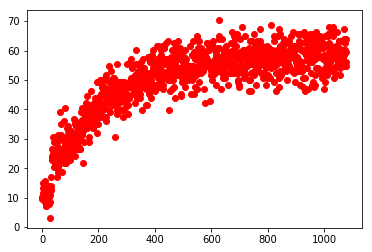

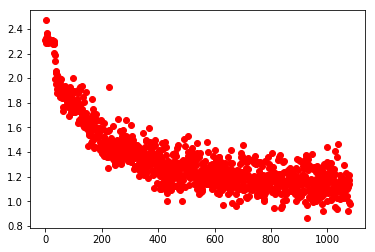

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

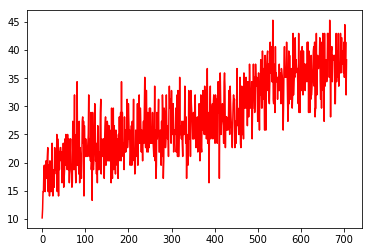

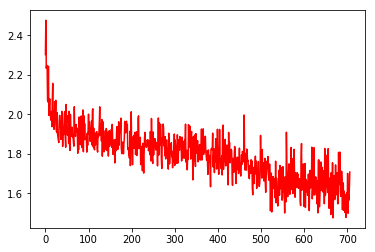

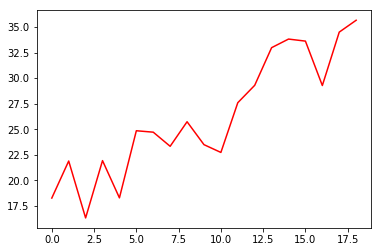

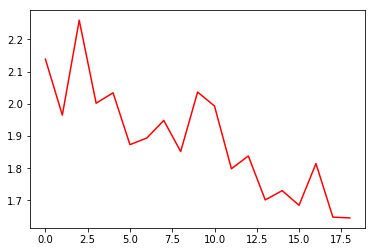

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()